# Импорт всего

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image as img
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Созадание и обучение нейронки (VGGFace)

In [ ]:
# ВАРИАНТ С ВГГФЭЙС (самый кастомный +_-)

! pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface

!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

vggface_model = VGGFace(model='resnet50')

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

# для кастомного препроцессинга, как у автора:
def preprocess_input_facenet(image):
    preprocessed = utils.preprocess_input(image, version=2) 
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [ ]:
vggface_model.summary()

In [ ]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.
# Это как в уроке:

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer('flatten').output) # тут иногда не работает, нужно смотреть на название слоя: бывает, что флаттен_1, 2
# и т. д. Название слоя сразу выше, в выходе прошлой ячейки
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dense(9, activation='softmax')]) 

In [ ]:
train_dir = '/content/drive/MyDrive/Skillbox/train/'
IMG_SHAPE = 224 # тут у нас по умолчанию такой вход, не будем его менять, оно ведь не стандартное, может и нет у него "input_shape"
# А может и есть - проверять не хотелось, и так кода много. 

train_gen = image_gen.flow_from_directory(batch_size=32,
                                          directory=train_dir,
                                          shuffle=True,
                                          target_size=(IMG_SHAPE, IMG_SHAPE),
                                          class_mode='categorical',
                                          color_mode = 'rgb')

Found 50046 images belonging to 9 classes.


## Переходим к обучению

In [ ]:
# Мне очень нравится эта штука для отрисовки процесса обучения в реальном времени.
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback 

In [ ]:
# Стандартная компилляция:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6),
              metrics=['accuracy']
              )

# Будем работать с чекпойнтом для экономии нервов, если дропнут от ГПУ/выключится свет/случайно нажму на слип/ и т. п.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Skillbox/coursework_NN_VGGFace.h5/',
                                                monitor='accuracy',
                                                verbose=1,
                                                save_best_only=True, mode='max')

In [ ]:
model.load_weights('/content/drive/MyDrive/Skillbox/coursework_NN_VGGFace.h5/')

In [ ]:
# Запустим цикл обучения(по тому варианту нейронки, которую выбрали)
# Сейчас это ВГГ
history = model.fit(train_gen, epochs=100, steps_per_epoch=150,
                    callbacks=[PlotLossesCallback(), checkpoint])

Epoch 1/100
  1/150 [..............................] - ETA: 50:08 - loss: 0.9620 - accuracy: 0.5938

# Предсказания тестовой выборки


In [ ]:
# Это сработало в джупитере... О, и здесь сработало!
from os import listdir

path = '/content/drive/MyDrive/Skillbox/test_kaggle'
filelist = listdir(path)
len(filelist)

5000

In [ ]:
# Подготовим тестовые картинки к инференсу:
def prepare_to_inf(path):
  img = plt.imread(path)
  img = tf.image.resize(img, (IMG_SHAPE, IMG_SHAPE)).numpy()[None, ...]
  return img

In [ ]:
# Создадим функцию предсказания эмоции, она понадобится для инференса и потом для определения эмоции по скриншоту с камеры:
path = '/content/drive/MyDrive/Skillbox/test_kaggle/56.jpg'
def predict_emotion(path):
  s = model.predict(prepare_to_inf(path), workers=-1)
  emotion = np.argmax(s).astype(int)
  return emotion

In [ ]:
# Проверим время инференса, по условию он не должен превышать 0.33 сек:
%%timeit
emotion = predict_emotion(path)
emotion
# Удовлетворяет

The slowest run took 29.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 78.2 ms per loop


In [ ]:
# Это быстрый способ:
pred_list = []
for i in filelist:
  em = predict_emotion(directory+'/'+i)
  pred_list.append(em)
pred_list

In [ ]:
import pandas as pd
df_1 = pd.DataFrame(filelist, columns=['image_path'])
df_1['emotion'] = pred_list #list_of_preds
df_1['emotion'] = df_1['emotion'].map({0: 'anger', 1: 'contempt', 2: 'disgust',
                                   3: 'fear', 4: 'happy', 5: 'neutral',
                                   6: 'sad', 7: 'surprise', 8: 'unsertain'
                                   })

# Сохраним предсказания в файл, который будем загружать на kaggle:
%cd /content/drive/MyDrive/Skillbox
df_1.to_csv('emotion_prediction_1.csv', sep=',', encoding='utf8', index=False)
df_1.head()

/content/drive/MyDrive/Skillbox


,image_path,emotion
0,4000.jpg,surprise
1,4001.jpg,sad
2,4002.jpg,neutral
3,4003.jpg,sad
4,4004.jpg,contempt


# Image capture, face detection

In [ ]:
# Функция отрисовки графика распределения вероятности эмоций:
# Будем реалистами. Нет точных предсказаний, особенно в той области, что касается человеческих эмоций. Ведь иногда самому человеку до
# конца не ясно, что он чувствует.
def emotion_analysis(emotions):
  objects = ['anger','contempt', 'disgust', 'fear', 'happy', 'neutral',
                                   'sad', 'surprise', 'unsertain'] # Список эмоций
  y_pos = np.arange(len(objects))

  plt.bar(y_pos, emotions, align='center', alpha=0.5)
  plt.xticks(y_pos, objects, rotation=45)
  plt.ylabel('percentage')
  plt.title('emotion')
  plt.show()

## Функция скриншота с камеры

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/drive/MyDrive/Skillbox/coursework_tests/photo.jpg', quality=0.8):
  js = Javascript('''
      async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Рамочка с лицом и предсказание эмоции

In [ ]:
screenshot = take_photo() # это делает и сохраняет скриншот с веб-камеры

<IPython.core.display.Javascript object>

In [ ]:
# Cоздание рамочки для лица (face detection):
import cv2

def facecrop(image): # оригинально это была функция обрезки лица из общей картины, отсюда слово "crop"
  facedata = '/content/drive/MyDrive/Skillbox/haarcascade_frontalface_alt.xml'
  cascade = cv2.CascadeClassifier(facedata)
  em_legend = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'unsertain'}
  img = cv2.imread(image)

  try:
    minisize = (img.shape[1], img.shape[0])
    miniframe = cv2.resize(img, minisize)
    faces = cascade.detectMultiScale(img)
    # emotion = predict_emotion(screenshot)
# создание собственно рамочки:
    for f in faces:
      x, y, w, h = [v for v in f]
      cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
# Это обрезка и нам она нужна для предсказаний:
      sub_face = img[y:y+h, x:x+w]
      screnn_inf = tf.image.resize(sub_face, (IMG_SHAPE, IMG_SHAPE)).numpy()[None, ...]
      customs = model.predict(screnn_inf)
      cv2.putText(img, em_legend.get(np.argmax(customs[0])), (x+10, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
# А это мы будем выводить на печать:
      just_detect = img
# В итоге получим скриншот с камеры, где лица будут обведены рамкой:
      cv2.imwrite('/content/drive/MyDrive/Skillbox/coursework_tests/capture.jpg', just_detect) # Адрес скриншота
  
  except Exception as e:
    print(e)
  return customs # вернем предсказания на выход, чтобы потом использовать в дальнейших манипуляциях


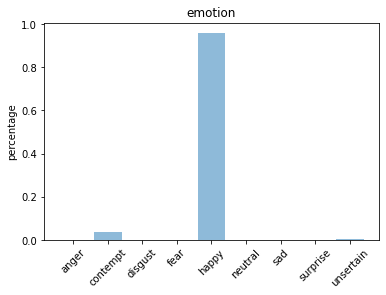

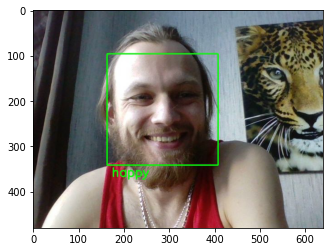

In [ ]:
# Предсказание эмоций по рамочке и финальный выход всего пайплайна по face detection:
customs = facecrop(screenshot)
if __name__ == '__main__':
  facecrop(screenshot)

file = '/content/drive/MyDrive/Skillbox/coursework_tests/capture.jpg'

true_image = image.load_img(file)
img = image.load_img(file, color_mode='rgb', target_size=(224, 224, 3))

emotion_analysis(customs[0])

plt.imshow(true_image)
plt.show()